In [5]:
import numpy as np
import os
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline
import sys
sys.path.append("../utils")
sys.path.append("../")
import utils.util_lookup_table
import utils.util_data
from pprint import pprint

In [6]:
[f[:-4] for f in os.listdir("./results")]
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

private_preamble QPSK_neural_vs_poly 8_4
[14.599999999999913, 12.999999999999918, 11.999999999999922, 10.399999999999928, 8.399999999999935, 4.1999999999999496]
[0.19382   0.1308825 0.12585   0.1249675 0.124945  0.12491  ]
[1.12920e-01 1.31175e-02 2.16500e-03 2.82500e-04 4.75000e-05 2.50000e-06]
[0.2027675 0.13364   0.126945  0.12577   0.125535  0.1256175]
private_preamble QPSK_neural_vs_selfalien 8_4
[14.599999999999913, 12.999999999999918, 11.999999999999922, 10.399999999999928, 8.399999999999935, 4.1999999999999496]
[1.051675e-01 1.040000e-02 1.372500e-03 1.375000e-04 2.000000e-05
 0.000000e+00]
[1.02585e-01 9.46000e-03 1.16750e-03 1.07500e-04 1.00000e-05 0.00000e+00]
[1.24355e-01 1.23300e-02 1.80000e-03 2.65000e-04 4.50000e-05 2.50000e-06]
private_preamble QPSK_poly_vs_clone 8_4
[14.599999999999913, 12.999999999999918, 11.999999999999922, 10.399999999999928, 8.399999999999935, 4.1999999999999496]
[1.42045e-01 2.17750e-02 4.89750e-03 1.01000e-03 3.02500e-04 2.75000e-05]
[1.122375e-0

/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:1398: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))


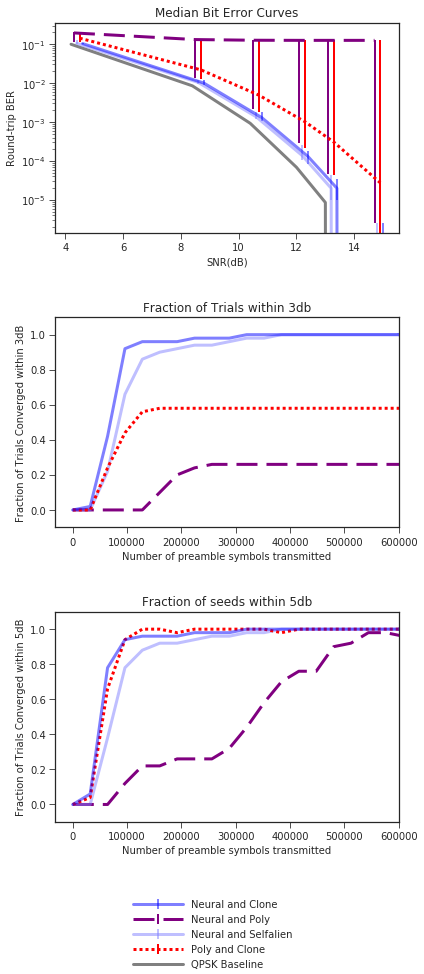

In [41]:
br = utils.util_lookup_table.BER_lookup_table()
plt.style.use('seaborn-ticks')
color = {
 'QPSK_classic_and_neural':"r",
 'QPSK_neural_vs_clone':"r",
 'QPSK_neural_and_neural':"g",
 'QPSK_neural_vs_selfalien':'g',
 'QPSK_neural_and_classic':"b",
 'QPSK_neural_vs_poly':'y',
 'QPSK_neural_vs_classic':"orange",
 'QPSK_poly_vs_clone':"blue",
}

LINE_STYLES = {
               'neural_vs_poly': (0, (7, 3)),
               'poly_vs_clone':(0, (1, 1)),
               'neural_vs_clone':'solid',#(0, (2, 7)),
               'neural_vs_selfalien':'solid',
              }
DARKEN_BY = {
               'neural_vs_poly':1,
               'poly_vs_clone':1,
               'neural_vs_clone':1,
               'neural_vs_selfalien':.5
            }

COLORS = {
               'neural_vs_poly':'purple',
               'poly_vs_clone':'r',
               'neural_vs_clone':'b',
               'neural_vs_selfalien':'b'
            }

fig,(ber, db3, db5) = plt.subplots(3, 1)
fig.set_figheight(4.5*3)
fig.set_figwidth(6)
# for ax in axes:
#     ax.set_aspect('equal', adjustable="datalim")
# (ber, db3, db5) = axes
# fig.suptitle('Private w/ QPSK at 8.4dB Training SNR')
baseline=False
must_include = ['private', '8_4']
must_exclude = ['classic']#['poly', 'selfalien']
k=0
for experiment_name in os.listdir("./results/"):
    if (not all([_ in experiment_name for _ in must_include])) \
        or any([_ in experiment_name for _ in must_exclude]):
        continue
    k+=1
    f = os.path.join("./results", experiment_name)
    protocol, experiment_name, snr = experiment_name[:-4].split("-")
    models = "_".join(experiment_name.split("_")[1:])
    print(protocol, experiment_name, snr)
    snr = float(snr.replace("_","."))
    r = np.load(f, allow_pickle=True).item()    
    fs_x = np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0]
    print(r['test_SNR_dbs'])
    fs_mid = np.fliplr(np.array(r['BER_mid']).reshape((1, 6)))[0]
    fs_low = np.fliplr(np.array(r['BER_low']).reshape((1, 6)))[0]
    fs_high = np.fliplr(np.array(r['BER_high']).reshape((1, 6)))[0]
    ckey = models
    dkey= models
    lkey= models
    right = 600000
    inset = True
#     label = ", ".join([models, protocol]).replace("_", " ")
    label=models.replace("_", " ").title().replace("Vs", "and")
    print(fs_mid)
    print(fs_low)
    print(fs_high)
    ber.errorbar(
                    np.array(fs_x) + k*1e-1, 
                    fs_mid,  
                    yerr = [fs_mid - fs_low, fs_high- fs_mid], 
                    elinewidth = 2, 
                    linestyle = LINE_STYLES[lkey],
                    color = lighten_color(COLORS[ckey], amount=DARKEN_BY[dkey]),
                    #fmt = 'o-', 
                    label=label,
                    linewidth = 3,
                    alpha = .50 if LINE_STYLES[lkey] == "solid" else 1.0,
                )
    db3.plot([0.0]+r['symbols_sent']+[right], 
             np.concatenate(([0.0],r['3db_off'],r['3db_off'][-1:])),#'o-',
                    linestyle = LINE_STYLES[lkey],
                    color = lighten_color(COLORS[ckey], amount=DARKEN_BY[dkey]),
                    label=label,
                    linewidth = 3,
                    alpha=(.50 if LINE_STYLES[lkey] == "solid" else 1.0),
            )
    db5.plot([0.0]+r['symbols_sent']+[right], 
             np.concatenate(([0.0],r['5db_off'],r['5db_off'][-1:])),#'o-',\
                    linestyle = LINE_STYLES[lkey],
                    color = lighten_color(COLORS[ckey], amount=DARKEN_BY[dkey]),
                    label=label,
                    linewidth = 3,
                    alpha=(.50 if LINE_STYLES[lkey] == "solid" else 1.0),
            )
    if not baseline:
        ber_baseline = [br.get_optimal_BER_roundtrip(test_SNR_db, 2) 
                        for test_SNR_db in np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0]]
#         ber3_baseline = [br.get_optimal_BER_roundtrip(test_SNR_db-3, 2) 
#                         for test_SNR_db in np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0]]
#         ber5_baseline = [br.get_optimal_BER_roundtrip(test_SNR_db-5, 2) 
#                         for test_SNR_db in np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0]]
        ber.plot( np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0], 
              ber_baseline,#'o-b',
              label="QPSK Baseline", color ='gray', linewidth = 3, alpha=1)
#         ber.plot( np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0], 
#               ber3_baseline,#'o-b',
#               label="3db off", color ='gray', linewidth = 3, alpha=.8)
#         ber.plot( np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0], 
#               ber5_baseline,
#               label="5db off", color ='gray', linewidth = 3, alpha=.5)
        baseline=True
ber.set_aspect('equal')
ber.set_yscale('log')
ber.set_title("Median Bit Error Curves")
ber.set_xlabel('SNR(dB)')
ber.set_ylabel('Round-trip BER')
# ber.set_xlim(right=14.0)
# inset axes....
# if inset:
    
# ber.legend()

db3.set_ylim(top=1.1, bottom=-0.1)
db5.set_ylim(top=1.1, bottom=-0.1)
db3.set_xlim(right=right)
db5.set_xlim(right=right)

db3.set_title("Fraction of Trials within 3db")
db3.set_ylabel('Fraction of Trials Converged within 3dB')
db3.set_xlabel('Number of preamble symbols transmitted')

db5.set_title("Fraction of seeds within 5db")
db5.set_ylabel('Fraction of Trials Converged within 5dB')
db5.set_xlabel('Number of preamble symbols transmitted')
# db5.set_aspect('equal')
handles, labels = ber.get_legend_handles_labels()
order = sorted(range(len(labels)),key=labels.__getitem__)
# order = [order[i] for i in [0,2,1,4,3,5]] 
# order = [order[i] for i in [0,2,1]] 
handles = [handles[idx] for idx in order]
labels = [labels[idx] for idx in order]
# Put a legend below current axis
fig.legend(handles,                # The line objects
           labels,
           borderaxespad=0.1,    # Small spacing around legend box
#            title="Protocols and Models",  # Title for the legend
           loc='lower center',
           fancybox=True, shadow=True, ncol=1,
           handlelength=5
           )
fig.tight_layout()
# fig.subplots_adjust(top=0.85)
fig.subplots_adjust(bottom=0.15, hspace = 0.4)  
fig.savefig('./alien_tuned.pdf', format = 'pdf', bbox_inches='tight')
plt.show()

In [4]:
from compile_results import process_experiment
from pprint import pprint
import numpy as np
# import os
# os.listdir("./")
# process_experiment("./")
meta, r1 = np.load('20190813_040500_0.npy')[0], np.load('20190813_040500_0.npy')[1:]
r2 = np.load('20190813_040906_0.npy')[1:]
nequal = False
for i,j in zip(r1, r2):
    if i.keys() != j.keys():
        print("keys not eq ", i.keys(), j.keys())
        break
    for k in i.keys():
        nequal =  i[k]!=j[k]
        if isinstance(nequal, np.ndarray):
            nequal = np.any(nequal)
        if nequal:
            pprint(i[k])
            pprint(j[k])
            break
    if nequal:
        break

process_experiment("./")

{13: {'3db_off': array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1.]),
  '5db_off': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1.]),
  'BER_high': array([0.000e+00, 0.000e+00, 6.500e-05, 9.350e-04, 8.515e-03, 9.760e-02]),
  'BER_low': array([0.000e+00, 0.000e+00, 6.500e-05, 9.350e-04, 8.515e-03, 9.760e-02]),
  'BER_mid': array([0.000e+00, 0.000e+00, 6.500e-05, 9.350e-04, 8.515e-03, 9.760e-02]),
  'SNR_db_off_for': 8.399999999999935,
  'final_bers': array([[0.000e+00, 0.000e+00],
         [0.000e+00, 0.000e+00],
         [6.500e-05, 6.500e-05],
         [9.350e-04, 9.350e-04],
         [8.515e-03, 8.515e-03],
         [9.760e-02, 9.760e-02]]),
  'max_num_logs': 23,
  'num_trials': 2,
  'symbols_sent': [32,
   256,
   480,
   704,
   928,
   1152,
   1376,
   1600,
   1824,
   2048,
   2272,
   2496,
   2720,
   2944,
   3168,
   3392,
   3616,
   3840,
   4064,
   4288,
 

dict_keys([13])
dict_keys(['symbols_sent', 'BER_mid', 'BER_high', 'num_trials', 'final_bers', 'test_SNR_dbs', 'SNR_db_off_for', 'BER_low', '3db_off', '5db_off', 'max_num_logs'])


/Users/caryn/anaconda/envs/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_base.py:1376: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))


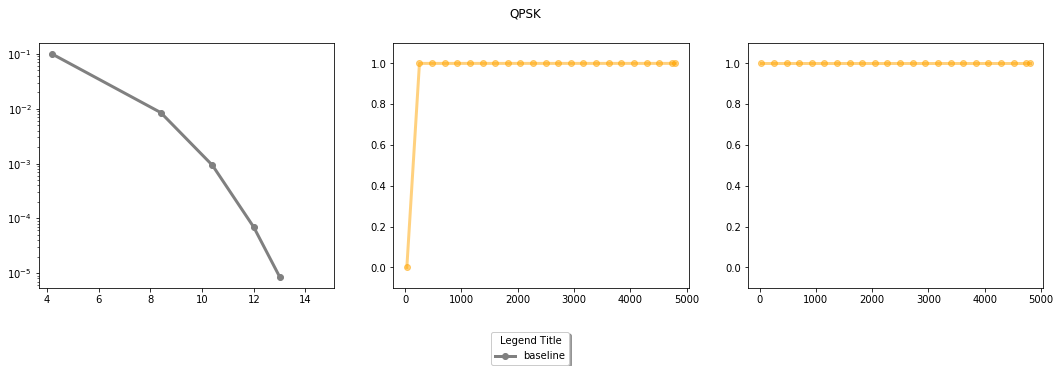

In [56]:
br = utils.util_lookup_table.BER_lookup_table()
color = {
 'QPSK_neural_vs_clone':"r",
 'QPSK_neural_vs_selfalien':'g',
 'QPSK_neural_vs_poly':'b',
 'QPSK_classic_and_neural':"orange",
 'QPSK_poly_vs_clone':"blue",
}
fig,(ber, db3, db5) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(6*3)
# for ax in axes:
#     ax.set_aspect('equal', adjustable="datalim")
# (ber, db3, db5) = axes
fig.suptitle('QPSK')
baseline=False

#     f = os.path.join("./results", experiment_name)
experiment_name = meta['experiment_name']
experiment_dict = process_experiment("./")
print(experiment_dict.keys())
mid_ber = sorted(experiment_dict.keys())[0]
r = experiment_dict[mid_ber]
print(r.keys())
#     print(r['test_SNR_dbs'], np.fliplr(np.array(r['BER_mid']).reshape((1, 6))))
# ber.plot( np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0], 
#           np.fliplr(np.array(r['BER_mid']).reshape((1, 6)))[0],'o-b', 
#           label=experiment_name, color = color[experiment_name], linewidth = 3)
db3.plot(r['symbols_sent'], r['3db_off'],'o-b',  label=experiment_name, color = color[experiment_name], linewidth = 3, alpha=.5)
db5.plot(r['symbols_sent'], r['5db_off'], 'o-b',label=experiment_name, color = color[experiment_name], linewidth = 3, alpha=.5)
if not baseline:
    ber_baseline = [br.get_optimal_BER_roundtrip(test_SNR_db, 2) 
                    for test_SNR_db in np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0]]
    ber.plot( np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0], 
          ber_baseline,'o-b',
          label="baseline", color ='gray', linewidth = 3)
    baseline=True
ber.set_aspect('equal')
ber.set_yscale('log')
# ber.legend()

db3.set_ylim(top=1.1, bottom=-0.1)
db5.set_ylim(top=1.1, bottom=-0.1)
# db5.set_aspect('equal')
handles, labels = ber.get_legend_handles_labels()



# Put a legend below current axis
fig.legend(handles,                # The line objects
           labels,
           borderaxespad=0.1,    # Small spacing around legend box
           title="Legend Title",  # Title for the legend
           loc='lower center',
           fancybox=True, shadow=True, ncol=5
           )
# fig.tight_layout()
fig.subplots_adjust(bottom=0.2)  
plt.show()

In [55]:
# plt.plot(ebnodb, psk81)
# plt.plot(ebnodb, qpsk1)
# plt.plot(ebnodb, qam161)
# plt.plot(test_SNR_dbs, psk8)
# plt.plot(test_SNR_dbs, qpsk)
# plt.plot(test_SNR_dbs, qam16)
# plt.xlabel("Eb/N0")
# plt.ylabel("BER")
# plt.yscale('log')
# plt.ylim(10e-9, 10e-1)
# plt.xlim(4, 16)
# plt.show()
# %BPSK BER
# const=[1 -1];
# size=100000;
# iter_max=1000;
# EbN0_min=0;
# EbN0_max=10;
# SNR=[];BER=[];
# for EbN0 = EbN0_min:EbN0_max
# EbN0_lin=10.^(0.1*EbN0);
# noise_var=0.5/(EbN0_lin); % s^2=N0/2
# iter = 0;
# err = 0;
# while (iter <iter_max && err <100),
# bits=randsrc(1,size,[0 1]);
# s=const(bits+1);
# ;
# bit_hat=(-sign(x)+1)/2;
# err = err + sum(bits ~= bit_hat);
# iter = iter + 1;
# 5
# end
# SNR =[SNR EbN0];
# BER = [BER err/(size*iter)];
# end
# semilogy(SNR,BER);grid;xlabel(’E_bN_0’);ylabel(’BER’);
# title(’BPSK over AWGN channel’);

ImportError: No module named 'models.modulators'

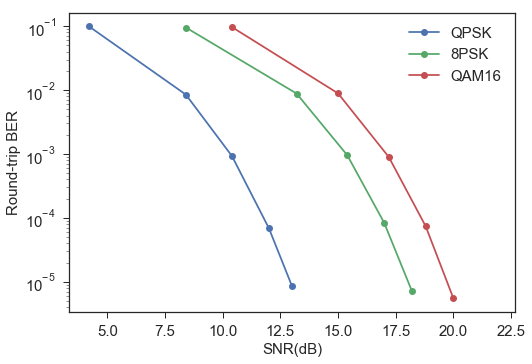

In [193]:
# plt.rcParams["font.family"] = "Times New Roman"
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('seaborn-ticks')
plt.rcParams.update({'xtick.labelsize' : 15, 'ytick.labelsize' : 15, 'axes.labelsize':15, 'legend.fontsize':15})
# plt.rcParams["figure.figsize"] = [16,10]
matplotlib.rc('font', size=30)
color = [0,0,"red","green","blue"]
label = [0,0,"QPSK","8PSK","QAM16"]
for bps in [2,3,4]:
    test_SNR_dbs = list(utils.util_data.get_test_SNR_dbs()[bps]['ber_roundtrip'])
    test_SNR_dbs.reverse()
    ber_baseline = [br.get_optimal_BER_roundtrip(test_SNR_db, bps) 
         for test_SNR_db in np.array(test_SNR_dbs)]
    plt.plot(test_SNR_dbs, ber_baseline,  marker='o',label=label[bps])
plt.xlabel("SNR(dB)")
plt.ylabel("Round-trip BER")
plt.yscale('log')
plt.legend()
# plt.title("Round-trip BER Curves")

plt.show()

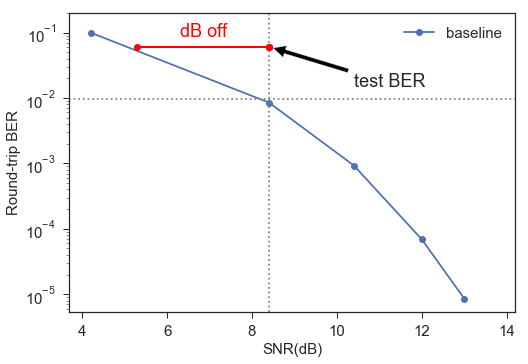

In [192]:
bps=2
# plt.style.use('seaborn')
test_SNR_dbs = list(utils.util_data.get_test_SNR_dbs()[bps]['ber_roundtrip'])
test_SNR_dbs.reverse()
ber_baseline = [br.get_optimal_BER_roundtrip(test_SNR_db, bps) for test_SNR_db in np.array(test_SNR_dbs)]
# ber3_baseline = [br.get_optimal_BER_roundtrip(test_SNR_db-3, bps) for test_SNR_db in np.array(test_SNR_dbs)]
# ber5_baseline = [br.get_optimal_BER_roundtrip(test_SNR_db-5, bps) for test_SNR_db in np.array(test_SNR_dbs)]
plt.plot(test_SNR_dbs, ber_baseline,  marker='o',label='baseline')
plt.scatter(8.4,br.get_optimal_BER_roundtrip(8.4-3, bps), color='red')
plt.gca().annotate('test BER', xy=(8.4,br.get_optimal_BER_roundtrip(8.4-3, bps)), 
                   xytext=(0.8, 0.8), textcoords='axes fraction',
                   horizontalalignment='right', verticalalignment='top',
            arrowprops=dict(facecolor='black', shrink=0.05),fontsize =18
            )
plt.axvline(x=8.4, ymin=0, ymax=1, linestyle='dotted', color='gray')
plt.axhline(y=0.0095, linestyle='dotted', color='gray')
pair_x = (8.4,5.3)
pair_y = (br.get_optimal_BER_roundtrip(8.4-3, bps), br.get_optimal_BER_roundtrip(8.4-3, bps))
plt.plot(pair_x, pair_y, 'red', marker='o', linewidth=2)
plt.gca().annotate('dB off', xy=(6.0,.1), textcoords='axes fraction', xytext=(.25,.92) ,fontsize =18, color='red')
# plt.plot(test_SNR_dbs, ber3_baseline,label='3db off')
# plt.plot(test_SNR_dbs, ber5_baseline,label='5db off')

plt.xlabel("SNR(dB)")
plt.ylabel("Round-trip BER")
plt.yscale('log')
plt.ylim(top=.2)
plt.xlim(right=14.2)
plt.legend()